In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qulacs import ParametricQuantumCircuit, QuantumCircuit, PauliOperator
from qulacs.gate import CZ, RY,RZ, merge, ParametricRY, ParametricRZ, PauliRotation
from qulacs import QuantumState, QuantumCircuit
from qulacs import DensityMatrix
from qulacs.gate import Probabilistic, Identity, X, Y, Z, T, DepolarizingNoise, RandomUnitary, P0, P1, add, merge, DephasingNoise
from qulacs.state import partial_trace, tensor_product
from qulacs.gate import SWAP
from qulacs.gate import H, S, Sdag, CNOT, SWAP, RZ
from qulacs import QuantumCircuit, QuantumState
from qulacs.observable import create_observable_from_openfermion_text

In [ ]:
def noisy_time_evolution(rho_input, layer, p_err):
    rho = rho_input.copy()
    for l in range(layer):
        DepolarizingNoise(0, p_err).update_quantum_state(rho)
    return rho



def symmetric_channel_verification(rho_input, layer, p_err, with_ancilla_noise = True):
    p_err_gadget = p_err
    rho = rho_input.copy()

    rho_ancilla = DensityMatrix(2)
    rho = tensor_product(rho_ancilla, rho)

    H(1).update_quantum_state(rho)
    if with_ancilla_noise:
        DepolarizingNoise(1, p_err_gadget).update_quantum_state(rho)

    CNOT(1, 0).update_quantum_state(rho)
    DepolarizingNoise(0, p_err_gadget).update_quantum_state(rho)
    if with_ancilla_noise:
        DepolarizingNoise(1, p_err_gadget).update_quantum_state(rho)
        DepolarizingNoise(2, p_err_gadget).update_quantum_state(rho)

    CNOT(0, 2).update_quantum_state(rho)
    if with_ancilla_noise:
        DepolarizingNoise(1, p_err_gadget).update_quantum_state(rho)
        DepolarizingNoise(2, p_err_gadget).update_quantum_state(rho)

    for l in range(layer):
        DepolarizingNoise(0, p_err).update_quantum_state(rho)
        if with_ancilla_noise:
            DepolarizingNoise(1, p_err).update_quantum_state(rho)
            DepolarizingNoise(2, p_err).update_quantum_state(rho)

    CNOT(0, 2).update_quantum_state(rho)
    DepolarizingNoise(0, p_err_gadget).update_quantum_state(rho)
    if with_ancilla_noise:
        DepolarizingNoise(1, p_err_gadget).update_quantum_state(rho)
        DepolarizingNoise(2, p_err_gadget).update_quantum_state(rho)

    CNOT(1, 0).update_quantum_state(rho)
    DepolarizingNoise(0, p_err_gadget).update_quantum_state(rho)
    if with_ancilla_noise:
        DepolarizingNoise(1, p_err_gadget).update_quantum_state(rho)

    H(1).update_quantum_state(rho)

    completely_mixed_state = DensityMatrix(1)
    completely_mixed_state.load(np.identity(2))
    projector = tensor_product(DensityMatrix(2), completely_mixed_state)

    rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
    rho.load(rho_matrix)

    rho = partial_trace(rho, [1, 2])

    return rho

def virtual_symmetric_channel_verification(rho_input, layer, p_err, with_ancilla_noise = True):
    p_err_gadget = p_err
    rho = rho_input.copy()

    rho_ancilla = DensityMatrix(2)
    rho = tensor_product(rho_ancilla, rho)

    H(1).update_quantum_state(rho)
    CNOT(1, 0).update_quantum_state(rho)
    CNOT(0, 2).update_quantum_state(rho)

    for l in range(layer):
        DepolarizingNoise(0, p_err).update_quantum_state(rho)

    CNOT(0, 2).update_quantum_state(rho)
    CNOT(1, 0).update_quantum_state(rho)
    H(1).update_quantum_state(rho)
    DepolarizingNoise(0, p_err_gadget).update_quantum_state(rho)

    completely_mixed_state = DensityMatrix(1)
    completely_mixed_state.load(np.identity(2))
    projector = tensor_product(DensityMatrix(2), completely_mixed_state)

    rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
    rho.load(rho_matrix)

    rho = partial_trace(rho, [1, 2])

    return rho

In [ ]:
n_qubit = 1
layer_list = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
p_err = 10**(-8)
seed = 1234

tracedist_noisy_list = np.zeros(len(layer_list))
tracedist_channel_list = np.zeros(len(layer_list))
tracedist_channel_virtual_list = np.zeros(len(layer_list))

for layer_index, layer in enumerate(layer_list):
    rho_initial = DensityMatrix(n_qubit)

    rho_ideal = noisy_time_evolution(rho_initial, layer, 0)
    rho_noisy = noisy_time_evolution(rho_initial, layer, p_err)
    rho_channel = symmetric_channel_verification(rho_initial, layer, p_err)
    rho_channel_virtual = virtual_symmetric_channel_verification(rho_initial, layer, p_err, with_ancilla_noise=False)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_channel = rho_channel.get_matrix()
    rho_channel_virtual = rho_channel_virtual.get_matrix()

    tracedist_noisy_list[layer_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_channel_list[layer_index] = np.linalg.norm(rho_ideal - rho_channel / np.trace(rho_channel), ord = 'nuc') / 2
    tracedist_channel_virtual_list[layer_index] = np.linalg.norm(rho_ideal - rho_channel_virtual / np.trace(rho_channel_virtual), ord = 'nuc') / 2

    print(layer)

1
2
5
10
20
50
100
200
500
1000


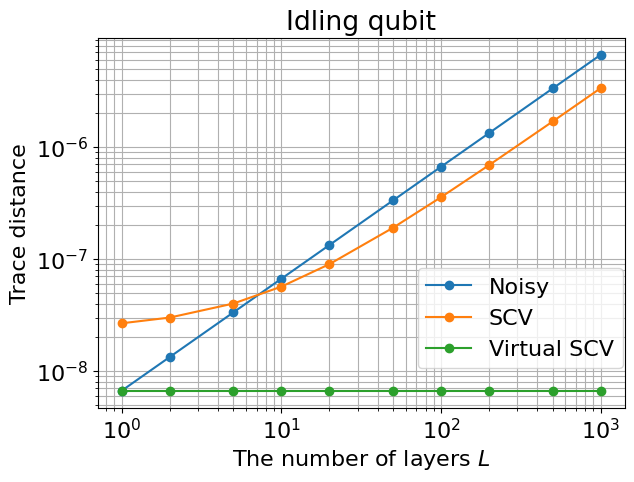

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(layer_list, tracedist_noisy_list, marker = 'o', label = 'Noisy')
plt.plot(layer_list, tracedist_channel_list, marker = 'o', label = 'SCV')
plt.plot(layer_list, tracedist_channel_virtual_list, marker = 'o', label = 'Virtual SCV')

plt.xscale('log')
plt.yscale('log')
plt.title('Idling qubit')
plt.xlabel('The number of layers $L$')
plt.ylabel('Trace distance')
#plt.xlim(0,22)
#plt.ylim(10**(-3.5),10**(-0.1))
plt.legend(bbox_to_anchor=(1,0.1),loc='lower right',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('Idling.pdf', bbox_inches='tight')

In [16]:
p_err = 10**(-8)
M_list = (np.arange(10) + 1) * 2
n_qubit_list = M_list**2 * 2

total_noise_list = (2 * M_list**2 + 6 * np.ceil(np.log2(M_list)) + 6) * (20 * M_list**2 + 1)
mitigated_noise_list = (6 * np.ceil(np.log2(M_list)) + 6) * (20 * M_list**2 + 1) + 14 * M_list**2

total_noise_list = total_noise_list * p_err
mitigated_noise_list = mitigated_noise_list * p_err

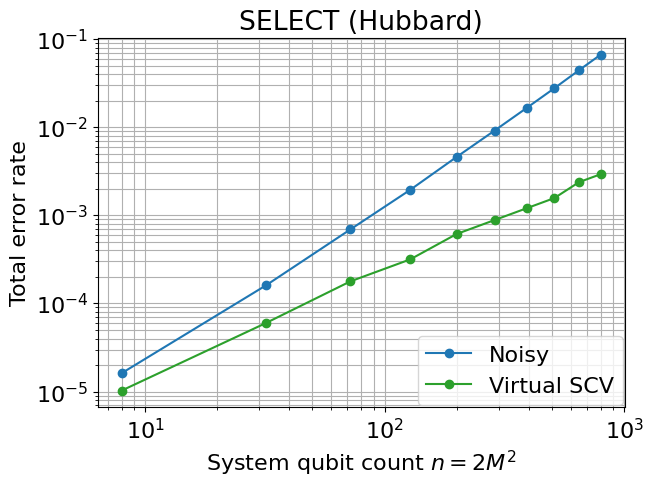

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(n_qubit_list, total_noise_list, marker = 'o', label = 'Noisy')
plt.plot(n_qubit_list, mitigated_noise_list, marker = 'o', label = 'Virtual SCV',color='#2ca02c')

plt.xscale('log')
plt.yscale('log')
plt.title('SELECT (Hubbard)')
plt.xlabel('System qubit count $n = 2M^2$')
plt.ylabel('Total error rate')
#plt.xlim(0,22)
#plt.ylim(10**(-3.5),10**(-0.1))
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('select.pdf', bbox_inches='tight')